# 랭그래프로 간단한 챗봇 만들기

## 필요 라이브러리 설치

In [1]:
##%pip install langgraph

## GPT 모델 설정

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_openai import ChatOpenAI

# 모델 초기화
model = ChatOpenAI(model="gpt-4o-mini")
model.invoke('안녕하세요!')

AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b547601dbd', 'id': 'chatcmpl-CiACwzFz3e2TUAovmt0A5Z88TInlA', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--bbdcd5de-ff69-4d9c-81b8-dd3aa6dca06a-0', usage_metadata={'input_tokens': 10, 'output_tokens': 10, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## 상태 정의
- `Annotated[T, func]`: 타입 T에 메타데이터나 동작을 추가할 때 사용
- `add_messages`: LangGraph가 제공하는 Reducer로 기존 메시지 리스트를 덮어쓰지않고 새로운 메시지를 리스트 뒤에 추가
  - `Reducer`? 함수형 프로그래밍에서 온 개념으로 기존 값과 새 값을 어떻게 합칠 것인가를 정의하는 함수

In [4]:
from typing import Annotated # annotated는 타입 힌트를 사용할 때 사용하는 함수
from typing_extensions import TypedDict # TypedDict는 딕셔너리 타입을 정의할 때 사용하는 함수

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    """
    State 클래스는 TypedDict를 상속받습니다.

    속성:
        messages (Annotated[list[str], add_messages]): 메시지들은 "list" 타입을 가집니다.
       'add_messages' 함수는 이 상태 키가 어떻게 업데이트되어야 하는지를 정의합니다.
        (이 경우, 메시지를 덮어쓰는 대신 리스트에 추가합니다)
    """
    messages: Annotated[list[str], add_messages]



## 그래프 정의
- StateGraph를 생성할 때 상태의 스키마로 State 전달
- 그래프가 처리할 데이터의 형태를 정의

In [5]:
graph_builder = StateGraph(State)

## 챗봇 노드 함수 정의

In [6]:
def generate(state: State):
    """
    주어진 상태를 기반으로 챗봇의 응답 메시지를 생성합니다.

    매개변수:
    state (State): 현재 대화 상태를 나타내는 객체로, 이전 메시지들이 포함되어 있습니다.
		
    반환값:
    dict: 모델이 생성한 응답 메시지를 포함하는 딕셔너리. 
          형식은 {"messages": [응답 메시지]}입니다.
    """ 
    return {"messages": [model.invoke(state["messages"])]}


graph_builder.add_node("generate", generate) # 그래프에 노드 추가

## 엣지 정의 및 컴파일

In [7]:
graph_builder.add_edge(START, "generate")
graph_builder.add_edge("generate", END)    

graph = graph_builder.compile()

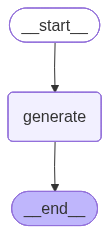

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception: 
    pass

## 그래프 실행
- 응답 메시지 : {'messages': [HumanMessage(...), AIMessage(...)]}

In [9]:
response = graph.invoke({"messages": ["안녕하세요! 저는 김정은입니다"]})

print(type(response))
response

<class 'dict'>


{'messages': [HumanMessage(content='안녕하세요! 저는 김정은입니다', additional_kwargs={}, response_metadata={}, id='2c057b53-4e4d-44bc-a117-8365f8598633'),
  AIMessage(content='안녕하세요, 김정은님! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 15, 'total_tokens': 30, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_67cf3fed12', 'id': 'chatcmpl-CiAD0x5KSGpsVNnfs29MB7DESYaZu', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--2910014c-f049-48d1-9dcd-3273cc31fd8e-0', usage_metadata={'input_tokens': 15, 'output_tokens': 15, 'total_tokens': 30, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]

In [10]:
response["messages"].append("제 이름을 아시나요?")
graph.invoke(response)

{'messages': [HumanMessage(content='안녕하세요! 저는 김정은입니다', additional_kwargs={}, response_metadata={}, id='2c057b53-4e4d-44bc-a117-8365f8598633'),
  AIMessage(content='안녕하세요, 김정은님! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 15, 'total_tokens': 30, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_67cf3fed12', 'id': 'chatcmpl-CiAD0x5KSGpsVNnfs29MB7DESYaZu', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--2910014c-f049-48d1-9dcd-3273cc31fd8e-0', usage_metadata={'input_tokens': 15, 'output_tokens': 15, 'total_tokens': 30, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),

## 스트리밍 출력

In [11]:
inputs = {"messages": [("human", "한국과 일본의 관계에 대해 자세히 알려줘")]}
for chunk, _ in graph.stream(inputs, stream_mode="messages"):
    print(chunk.content, end="")

한국과 일본의 관계는 역사적으로 복잡하고 다면적입니다. 이 두 나라의 관계는 여러 가지 측면에서 영향을 받아왔으며, 현재도 다양한 요소들에 의해 형성되고 있습니다. 아래에서 몇 가지 주요 측면을 살펴보겠습니다.

### 역사적 배경
1. **일제강점기 (1910-1945)**: 일본은 1910년부터 1945년까지 한국을 식민지로 지배했습니다. 이 기간 동안 한국의 문화, 언어, 경제가 억압받고 일본식으로의 동화가 강요되었습니다. 이로 인해 많은 한국인들이 일본에 대한 깊은 상처와 반감을 가지게 되었습니다.

2. **해방 이후**: 1945년 일본이 패망한 후 한국은 독립을 맞이했습니다. 그러나 일제 강점기 동안의 상처는 여전히 남아 있으며, 이로 인해 한국과 일본 간의 관계가 긴장 상태에 놓이게 됩니다.

### 현대의 주요 이슈
1. **위안부 문제**: 일본 제국주의 하의 성 착취 문제로, 많은 한국 여성들이 일본군의 위안부로 끌려갔습니다. 이 문제는 오늘날까지도 한국과 일본 간의 갈등의 주요 원인 중 하나입니다.

2. **징용 배상 문제**: 제2차 세계대전 중 강제 노역 문제도 중요한 이슈입니다. 한국인 징용자들이 일본에서 일했던 사실과 그에 대한 보상 문제는 여전히 해결되지 않은 상태입니다.

3. **독도 문제**: 한국과 일본 간의 영토 분쟁인 독도(일본명: 다케시마)는 두 나라 관계의 또 다른 갈등 요소입니다. 양국은 각각 독도의 주권을 주장하고 있으며, 이 문제는 정치적 긴장을 유발하고 있습니다.

### 경제 및 문화 교류
1. **경제 협력**: 한국과 일본은 경제적으로 긴밀한 관계를 맺고 있습니다. 두 나라는 서로의 주요 무역 파트너국이며, 기술 및 산업 협력도 활발하게 이뤄지고 있습니다.

2. **문화 교류**: K-팝, 드라마, 음식 등 한국의 문화가 일본에서 큰 인기를 얻으면서, 양국 간의 문화 교류도 활발해지고 있습니다. 이러한 문화 교류는 두 나라의 관계에 긍정적인 영향을 미치기도 합니다.

### 정치적 상황
한국과 일본의